# Algorithm principle

HR = high resolution
<br> LR = low resolution

The problem (ill-posed) is the following : we want to estimate the voxels of the HR image from the pixels of the low resolution image. To make it simpler, we can model the LR data as an average of the surrounding HR pixels :
$$y_j = \frac{1}{N} \sum_{i=1}^{N} x_i + n \text{,  where n is the Rician noise}$$
The idea would then be to estimate the $x_i$ from the $y_j$. We notice that there will be infinite values that will meet this condition. So we could first add a regularization term to limit the number of solutions, but regularization is known for destroying the high frequency content of the results, which is what we'd like to obtain.
#### Here comes the example-based method :
- Ideas : 1) Apply some filter to minimize the noise present in the LR data.
<br> 2) Reconstructed the image by applying high weights to voxels similar with the ones in the HR reference data, and to voxels with similar neighborhoods in the currently reconstructed data (reduces mis-alignements).
<br> 3) Subsampling consistency : impose the downsampled version of the reconstructed data to be the same as the original LR data
- Data required : HR reference data, preinterpolated LR data
- Iteratively update the reconstructed image voxels using the following idea : similar voxels in the HR tend to be similar in the reconstructed data, so averaging these with weights reflecting similar intensity in HR data and similar local context in LR data should help converging to a high frequency image, well aligned with the original LR image. Then, correct the voxels values so that they fit with the original LR data

#### The steps to follow are the following :
- Interpolate the LR data in order to get the same number of voxels than the HR reference.
- Denoise the LR data to reconstruct (and the reference HR data for voxel similarity computations) : (BNLM3D filter optimal) we'll use standard NL means version because seems to perform okay.
- Iterate till the mean_absolute_error of the reconstructed data gets inferior to some tolerance (we will do 5 iterations as it is very time consuming) :
<br, > 1) Reconstruction
<br, > 2) Mean correction : Nearest Neighbor interpolation (of the diff between the reconstructed data downsampled and the original LR data) withdrawn from the new reconstructed data.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.measure import block_reduce
from dipy.denoise.nlmeans import nlmeans
from dipy.denoise.noise_estimate import estimate_sigma
from skimage import exposure
%matplotlib inline

In [2]:
os.chdir('code_scripts')
import visualization as viz
import tools
import example_based as e_b
os.chdir('../')

# Preprocessing : creating LR images and denoising (Rician noise)

In [3]:
data_path = 'HR_data/'

HR_ref = np.load(data_path+'image1.npy')
scale = (np.min(HR_ref), np.max(HR_ref))

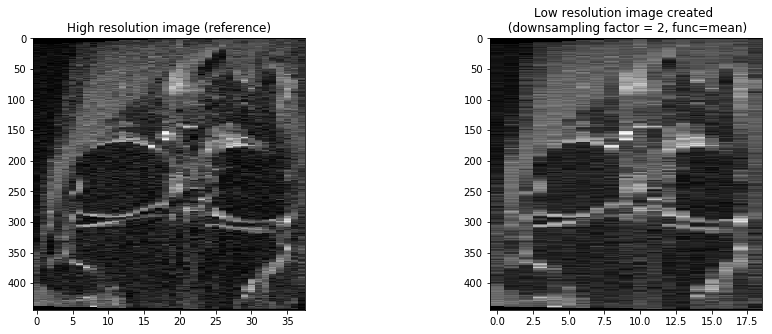

In [4]:
big_fig = plt.figure(1, figsize=(15,5))
    
fig = plt.subplot(121)
fig.set_title('High resolution image (reference)')
fig = viz.visualize_MRI_slice(HR_ref, 280, slice_direction=1) 
fig = plt.subplot(122)
fig.set_title('Low resolution image created \n (downsampling factor = 2, func=mean)')
LR_img = tools.downsample_z_axis(HR_ref, 2)
fig = viz.visualize_MRI_slice(LR_img, 280, slice_direction=1)

#### Denoising the LR image (Rician noise) - (HR should be denoised also, but need to be careful that it doesn't screw the HR content)

In [5]:
LR_denoised = tools.denoise(LR_img)

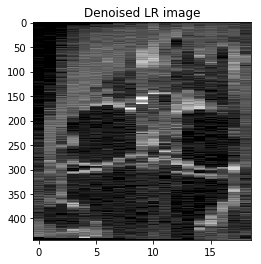

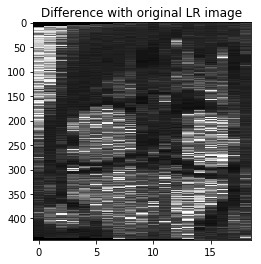

In [6]:
plt.title('Denoised LR image')
viz.visualize_MRI_slice(LR_denoised, 280, slice_direction=1)
plt.figure()
plt.title('Difference with original LR image')
viz.visualize_MRI_slice(LR_img-LR_denoised, 280, slice_direction=1)

#### Looking at the effects of denoising on the HR image (if no enhancement we shouldn't do it)
I think it enhances the results, and doesn't destroy the image structure

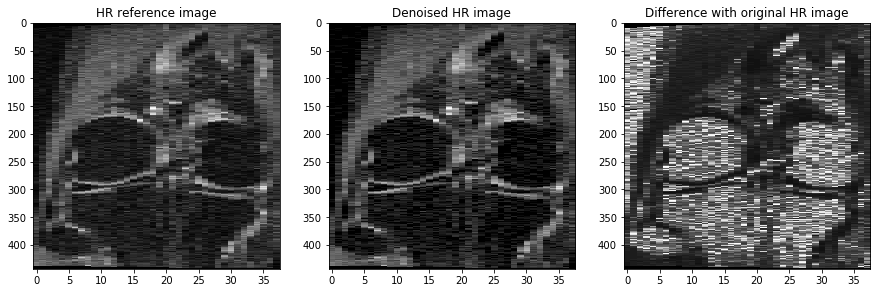

In [7]:
HR_denoised = tools.denoise(HR_ref)


big_fig = plt.figure(1, figsize=(15,5))
    
fig = plt.subplot(131)
fig.set_title('HR reference image')
fig = viz.visualize_MRI_slice(HR_ref, 280, slice_direction=1)
fig = plt.subplot(132)
fig.set_title('Denoised HR image')
fig = viz.visualize_MRI_slice(HR_denoised, 280, slice_direction=1)
fig = plt.subplot(133)
fig.set_title('Difference with original HR image')
fig = viz.visualize_MRI_slice(HR_ref-HR_denoised, 280, slice_direction=1)

## Upsampling (3-spline interpolation)

In [8]:
LR_img_interp = tools.spline_interpolation(LR_denoised, HR_ref.shape, 3)

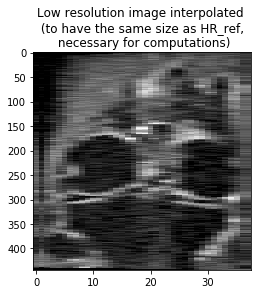

In [9]:
plt.title('Low resolution image created from HR_ref')
viz.visualize_MRI_slice(LR_img, 280, slice_direction=1)

plt.title('Low resolution image interpolated \n (to have the same size as HR_ref, \n necessary for computations)')
viz.visualize_MRI_slice(LR_img_interp, 280, slice_direction=1)

# Algorithm Implementation

In [10]:
params_algo = {
    'HR_data' : HR_denoised,
    'LR_data': LR_img,
    'reconstructed_data' : LR_img_interp.copy(),
    'search_radius' : 3,             # 7*7*7 search volume, to compute similarity with HR_ref
    'local_LR_radius' : 1,          # 3*3*3 local search volume for local similarity in LR)
    'h_values' : [32, 16, 8, 4, 2],
    'param_k' : 256
}

In [14]:
reconstructed_img = e_b.example_based_algo(**params_algo)

Step 0 begun
Small step 4


/Users/victordemurat/DS-GA1013/mri-super-resolution/code_scripts/example_based.py:55: RuntimeWarning: overflow encountered in ushort_scalars
  weight_1 = np.exp(-pow(HR_data[i,j,k]-HR_data[x,y,z],2)/pow(h,2))


KeyboardInterrupt: 

# Evaluation

In [11]:
res_path = 'Results/'
result_img = np.load(res_path+'reconstructed_img.npy')

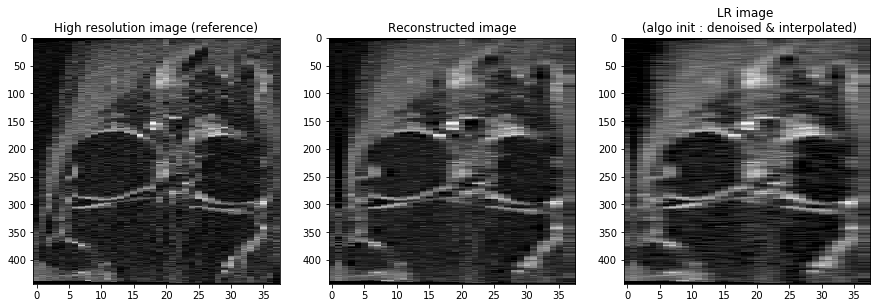

In [12]:
viz.improvements_visualization(HR_ref, result_img, LR_img_interp, 1, 280)

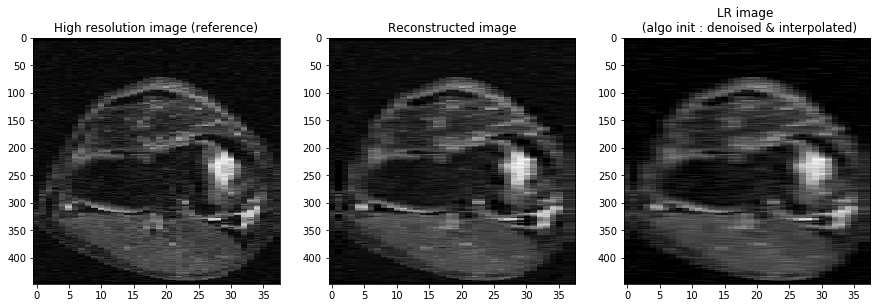

In [15]:
viz.improvements_visualization(HR_ref, result_img, LR_img_interp, 0, 310)

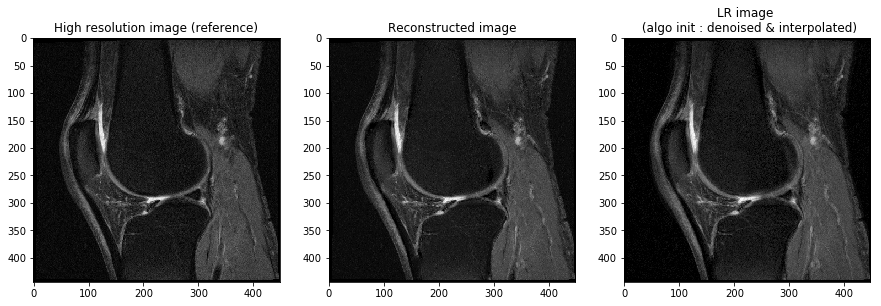

In [16]:
viz.improvements_visualization(HR_ref, result_img, LR_img_interp, 2, 15)

Signal-to-Noise ratio

In [23]:
result_img = exposure.rescale_intensity(result_img, scale)
LR_img_interp = exposure.rescale_intensity(LR_img_interp, scale)

In [29]:
HR_ref = (HR_ref - np.min(HR_ref)) * 255.0 / (np.max(HR_ref) - np.min(HR_ref))
print('SNR for HR_ref : ' + str(np.std(HR_ref[260:300,280,17:22])/np.std(HR_ref[210:250,280,9:14])))

SNR for HR_ref : 3.52514104495


In [28]:
LR_img = (LR_img - np.min(LR_img)) * 255.0 / (np.max(LR_img) - np.min(LR_img))
print('SNR for LR_img : ' + str(np.std(LR_img[260:300,280,17:22])/np.std(LR_img[210:250,280,9:14])))

SNR for LR_img : 1.02358139741


In [27]:
result_img = (result_img - np.min(result_img)) * 255.0 / (np.max(result_img) - np.min(result_img))
print('SNR for the reconstructed img : ' + str(np.std(result_img[260:300,280,17:22])/np.std(result_img[210:250,280,9:14])))

SNR for the reconstructed img : 3.93499465361
